In [3]:
import dataloader
import sys
import time
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import gc

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Flatten, TimeDistributed

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

%load_ext autoreload
%autoreload 2

path = "../032721Comparison/Data/AMZN2021.csv"
date = datetime.datetime(2021,3,12)
count = 1200
# We will use the previous 60 days as features
history_size = 60

In [4]:
# Compute MAE
def mae(y_hat, y):
    # mean absolute error
    return np.abs(y_hat - y).mean()

def rmse(y_hat, y):
    # root mean squared error
    return np.sqrt(np.mean(np.power((y-y_hat),2)))

In [5]:
df = dataloader.load_data_up_to_date(path, date, count)

(1258, 7)
(1257, 7)
(1257, 7)
(1200, 7)


In [6]:
amzn_closing_all = df['Close'].to_numpy()
# reshape to 1200 x 1 matrix
amzn_closing_all = np.reshape(amzn_closing_all, (amzn_closing_all.shape[0], -1))
amzn_closing_all.shape

(1200, 1)

In [7]:
#converting prices to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(amzn_closing_all)
train = scaled_data[:1000,:]
test = scaled_data[1000:, :]

In [8]:
train_x, train_y = [], []
test_x, test_y = [], []
for i in range(history_size,len(train)):
    train_x.append(scaled_data[i-history_size:i,0])
    train_y.append(scaled_data[i,0])
train_x, train_y = np.array(train_x), np.array(train_y)

train_x = np.reshape(train_x, (train_x.shape[0],train_x.shape[1], 1))
print(train_x.shape)

for i in range(len(train),len(scaled_data)):
    test_x.append(scaled_data[i-history_size:i,0])
    test_y.append(scaled_data[i,0])
test_x, test_y = np.array(test_x), np.array(test_y)

test_x = np.reshape(test_x, (test_x.shape[0],test_x.shape[1], 1))
print(test_x.shape)



(940, 60, 1)
(200, 60, 1)


In [9]:
# How many features do we want to pass as hidden unit
UNITS = range(2, 60, 2)
K = 5
model = None
gc.collect()

best_unit_count = None
# Best Validation Error
best_err = sys.maxsize

for unit_count in UNITS:
    kf = KFold(n_splits=K, random_state=None, shuffle=False)
    y_err = []
    
    
    # Cross Validaiton
    for train_index, val_index in kf.split(train_x):
        X_train, X_val = train_x[train_index], train_x[val_index]
        y_train, y_val = train_y[train_index], train_y[val_index]
    
        model = Sequential()
        model.add(LSTM(units=unit_count, return_sequences=True, input_shape=(train_x.shape[1],train_x.shape[2])))
        model.add(Flatten())
        model.add(Dense(unit_count))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)
        y_hat = model.predict(X_val).transpose()[0]
        del model
        gc.collect()
        
        y_err.append(rmse(y_hat, y_val))
        
    print(str(unit_count), "mean val RMSE:", np.mean(y_err))

    if np.mean(y_err) < best_err:
        best_err = np.mean(y_err)
        best_unit_count = unit_count

print(best_unit_count, best_err)

2 mean val RMSE: 0.02667639770893341
4 mean val RMSE: 0.023117700631743072
6 mean val RMSE: 0.021418739282414338
8 mean val RMSE: 0.019846172533759376
10 mean val RMSE: 0.019195707172577472
12 mean val RMSE: 0.024804038652183065
14 mean val RMSE: 0.019073125415161974
16 mean val RMSE: 0.019384566040210337
18 mean val RMSE: 0.018126618966208083
20 mean val RMSE: 0.023565601436006934
22 mean val RMSE: 0.022962697488080074
24 mean val RMSE: 0.018204923725876128
26 mean val RMSE: 0.017729712441487126
28 mean val RMSE: 0.016753870770169467
30 mean val RMSE: 0.02155624898871661
32 mean val RMSE: 0.015642473234585126
34 mean val RMSE: 0.016157483734254872
36 mean val RMSE: 0.02003340951946626
38 mean val RMSE: 0.018938431295758035
40 mean val RMSE: 0.020892749492695668
42 mean val RMSE: 0.019707102460035434
44 mean val RMSE: 0.016392295890331643
46 mean val RMSE: 0.014715087710953178
48 mean val RMSE: 0.017094962026848615
50 mean val RMSE: 0.017380588600407403
52 mean val RMSE: 0.019828960442

In [10]:
model = None
gc.collect()

model = Sequential()
model.add(LSTM(units=best_unit_count, return_sequences=True, input_shape=(train_x.shape[1],train_x.shape[2])))
model.add(Flatten())
model.add(Dense(best_unit_count))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_x, train_y, epochs=1000, batch_size=16, verbose=1)
print(model.summary())
y_hat = model.predict(test_x).transpose()[0]

del model
gc.collect()

Epoch 1/1000
59/59 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 2/1000
59/59 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 3/1000
59/59 [==============================] - 0s 8ms/step - loss: 6.5046e-04
Epoch 4/1000
59/59 [==============================] - 0s 7ms/step - loss: 5.8059e-04
Epoch 5/1000
59/59 [==============================] - 0s 8ms/step - loss: 4.8803e-04
Epoch 6/1000
59/59 [==============================] - 0s 8ms/step - loss: 5.0215e-04
Epoch 7/1000
59/59 [==============================] - 0s 8ms/step - loss: 4.9788e-04
Epoch 8/1000
59/59 [==============================] - 0s 8ms/step - loss: 4.1572e-04
Epoch 9/1000
59/59 [==============================] - 0s 8ms/step - loss: 5.8377e-04
Epoch 10/1000
59/59 [==============================] - 0s 8ms/step - loss: 3.5713e-04
Epoch 11/1000
59/59 [==============================] - 0s 8ms/step - loss: 4.2993e-04
Epoch 12/1000
59/59 [==============================] - 0s 8ms/step - lo

59/59 [==============================] - 0s 3ms/step - loss: 1.2300e-04
Epoch 191/1000
59/59 [==============================] - 0s 2ms/step - loss: 1.2201e-04
Epoch 192/1000
59/59 [==============================] - 0s 2ms/step - loss: 1.3949e-04
Epoch 193/1000
59/59 [==============================] - 0s 2ms/step - loss: 1.4677e-04
Epoch 194/1000
59/59 [==============================] - 0s 3ms/step - loss: 1.2719e-04
Epoch 195/1000
59/59 [==============================] - 0s 5ms/step - loss: 1.3895e-04
Epoch 196/1000
59/59 [==============================] - 0s 6ms/step - loss: 1.6342e-04
Epoch 197/1000
59/59 [==============================] - 0s 7ms/step - loss: 1.3425e-04
Epoch 198/1000
59/59 [==============================] - 0s 7ms/step - loss: 1.3522e-04
Epoch 199/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.5820e-04
Epoch 200/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.6899e-04
Epoch 201/1000
59/59 [==============================] - 0s

59/59 [==============================] - 0s 3ms/step - loss: 1.2097e-04
Epoch 379/1000
59/59 [==============================] - 0s 6ms/step - loss: 1.2396e-04
Epoch 380/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.1551e-04
Epoch 381/1000
59/59 [==============================] - 0s 7ms/step - loss: 1.1733e-04
Epoch 382/1000
59/59 [==============================] - 0s 7ms/step - loss: 1.2111e-04
Epoch 383/1000
59/59 [==============================] - 0s 6ms/step - loss: 1.1716e-04
Epoch 384/1000
59/59 [==============================] - 0s 7ms/step - loss: 1.2100e-04
Epoch 385/1000
59/59 [==============================] - 0s 3ms/step - loss: 1.3067e-04
Epoch 386/1000
59/59 [==============================] - 0s 6ms/step - loss: 1.1318e-04
Epoch 387/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.1716e-04
Epoch 388/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.1999e-04
Epoch 389/1000
59/59 [==============================] - 0s

59/59 [==============================] - 0s 8ms/step - loss: 1.2096e-04
Epoch 567/1000
59/59 [==============================] - 0s 4ms/step - loss: 1.1679e-04
Epoch 568/1000
59/59 [==============================] - 0s 7ms/step - loss: 1.0794e-04
Epoch 569/1000
59/59 [==============================] - 0s 5ms/step - loss: 1.2133e-04
Epoch 570/1000
59/59 [==============================] - 0s 5ms/step - loss: 1.1229e-04
Epoch 571/1000
59/59 [==============================] - 0s 7ms/step - loss: 1.0586e-04
Epoch 572/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.1627e-04
Epoch 573/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.2320e-04
Epoch 574/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.1073e-04
Epoch 575/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.1688e-04
Epoch 576/1000
59/59 [==============================] - 0s 7ms/step - loss: 1.2313e-04
Epoch 577/1000
59/59 [==============================] - 0s

59/59 [==============================] - 0s 8ms/step - loss: 1.1153e-04
Epoch 755/1000
59/59 [==============================] - 0s 7ms/step - loss: 1.1781e-04
Epoch 756/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.2435e-04
Epoch 757/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.2046e-04
Epoch 758/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0731e-04
Epoch 759/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.2446e-04
Epoch 760/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0799e-04
Epoch 761/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0750e-04
Epoch 762/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.2584e-04
Epoch 763/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.1056e-04
Epoch 764/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.1350e-04
Epoch 765/1000
59/59 [==============================] - 0s

59/59 [==============================] - 0s 8ms/step - loss: 1.2360e-04
Epoch 943/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.1507e-04
Epoch 944/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.2669e-04
Epoch 945/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0725e-04
Epoch 946/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0464e-04
Epoch 947/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.1168e-04
Epoch 948/1000
59/59 [==============================] - 0s 7ms/step - loss: 1.0647e-04
Epoch 949/1000
59/59 [==============================] - 0s 7ms/step - loss: 1.0521e-04
Epoch 950/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0668e-04
Epoch 951/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.1127e-04
Epoch 952/1000
59/59 [==============================] - 0s 8ms/step - loss: 1.0166e-04
Epoch 953/1000
59/59 [==============================] - 0s

20602

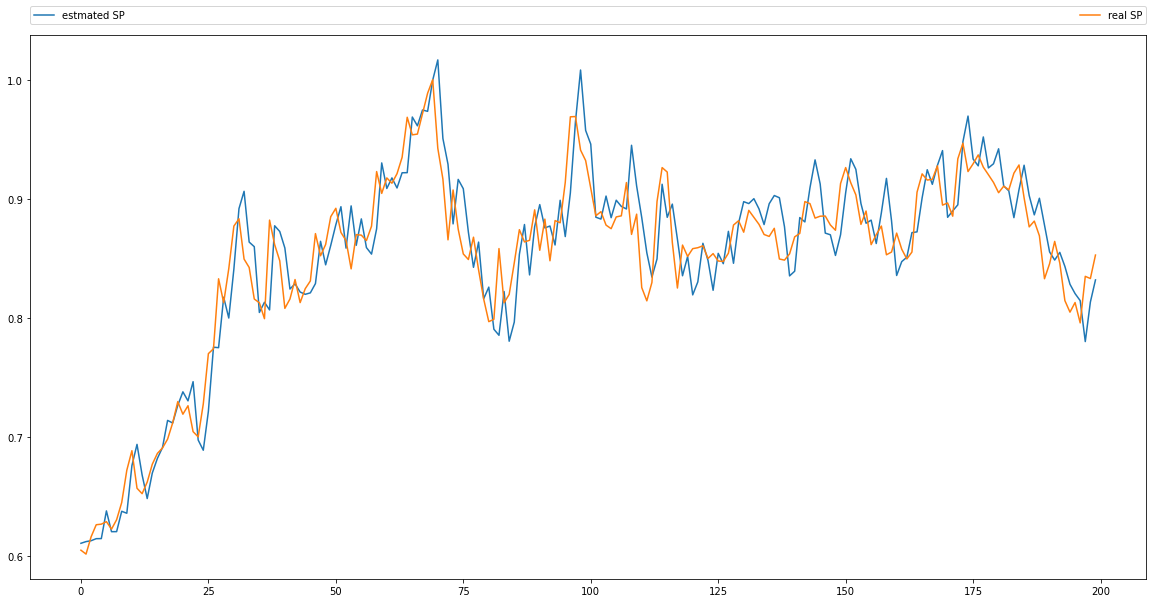

In [11]:
plt.plot(y_hat[:], label="estmated SP")
plt.plot(test_y[:], label="real SP")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

In [12]:
print("MAE:  ", mae(y_hat, test_y))
print("RMSE: ", rmse(y_hat, test_y))

MAE:   0.022116695570911782
RMSE:  0.028298113212104948


In [13]:
model = None
gc.collect()

3196